In [5]:
import cv2
import pytesseract 
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.animation
import numpy as np
import pandas as pd
import seaborn as sns
import math
from IPython.display import HTML

## Reading the Dataset

In [6]:
data = pd.read_excel('DigitalData.xlsx', sheet_name = 'CPET')
patient_info = pd.read_excel('DigitalData.xlsx', sheet_name = 'Patient')
patient_info['BMI']=patient_info['weight-kg']/(patient_info['height-cm']/100)**2
data_filt=data[['PatientId','Time','TestLevel','HR','VO2','VO2/kg','VCO2','VE','VEO2','VECO2','FE02','FECO2','RER','RR','METS','TMSPD','TMELV','Source','TypeUser']]

In [7]:
minutes = []
for i in data_filt.Time:
    minutes.append(i.second/60+i.minute)
data_filt['minutes']=np.array(minutes)

C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
patients_complete_only = data_filt.dropna().copy()
patients_complete_only['VO2/HR']=patients_complete_only.VO2/patients_complete_only.HR*1000
final_info = patients_complete_only.join(patient_info.set_index('patientid'), on="PatientId")
final_info['ID'] = final_info.index

## Creating the 30s averaged dataset

In [9]:
def round_to_30s(row):
    base = np.floor(row.minutes)
    med = base +0.5
    sup = np.round(row.minutes)
    if row.minutes <= med:
        return med
    else:
        return sup
    pass

In [10]:
patient_times = final_info.groupby(['PatientId'])['minutes'].max().reset_index()
patient_times['max_time'] = patient_times.apply(round_to_30s, axis=1)
df_info_avg = pd.DataFrame(columns = ['PatientId','minutes'])
for i in patient_times.PatientId:
    patient_time_min = np.arange(0.5,patient_times.loc[patient_times.PatientId==i]['max_time'].values[0],.5)
    #print(patient_time_min)
    patient_ids=np.ones(patient_time_min.shape)*i
    #print(patient_ids)
    tempdf = pd.DataFrame({'PatientId': patient_ids, 'minutes': patient_time_min })
    #print(tempdf)
    df_info_avg=df_info_avg.append(tempdf, ignore_index=True)
    pass

In [11]:
def round_to_mean(column, row):
    return np.mean(final_info.loc[(final_info.PatientId == row.PatientId) & 
                   (final_info.minutes >= (row.minutes-0.5)) &
                   (final_info.minutes < (row.minutes))][column].values)

In [12]:
def place_labels(column, row):
    return final_info.loc[(final_info.PatientId == row.PatientId) & 
                   (final_info.minutes >= (row.minutes-0.5)) &
                   (final_info.minutes < (row.minutes))][column].values[0]

In [13]:
df_info_avg['HR']=np.round(df_info_avg.apply(lambda x: round_to_mean('HR',x),axis=1),0)
df_info_avg['VO2']=df_info_avg.apply(lambda x: round_to_mean('VO2',x),axis=1)
df_info_avg['VO2/kg']=df_info_avg.apply(lambda x: round_to_mean('VO2/kg',x),axis=1)
df_info_avg['VCO2']=df_info_avg.apply(lambda x: round_to_mean('VCO2',x),axis=1)
df_info_avg['VE']=df_info_avg.apply(lambda x: round_to_mean('VE',x),axis=1)
df_info_avg['VEO2']=df_info_avg.apply(lambda x: round_to_mean('VEO2',x),axis=1)
df_info_avg['VECO2']=df_info_avg.apply(lambda x: round_to_mean('VECO2',x),axis=1)
df_info_avg['FE02']=df_info_avg.apply(lambda x: round_to_mean('FE02',x),axis=1)
df_info_avg['FECO2']=df_info_avg.apply(lambda x: round_to_mean('FECO2',x),axis=1)
df_info_avg['RER']=df_info_avg.apply(lambda x: round_to_mean('RER',x),axis=1)
df_info_avg['RR']=df_info_avg.apply(lambda x: round_to_mean('RR',x),axis=1)
df_info_avg['METS']=df_info_avg.apply(lambda x: round_to_mean('METS',x),axis=1)
df_info_avg['TMSPD']=df_info_avg.apply(lambda x: round_to_mean('TMSPD',x),axis=1)
df_info_avg['TMELV']=df_info_avg.apply(lambda x: round_to_mean('TMELV',x),axis=1)
df_info_avg['VO2/HR']=df_info_avg.apply(lambda x: round_to_mean('VO2/HR',x),axis=1)
df_info_avg['BMI']=df_info_avg.apply(lambda x: round_to_mean('BMI',x),axis=1)
df_info_avg['TypeUser']=df_info_avg.apply(lambda x: place_labels('TypeUser',x),axis=1)
df_info_avg['TestLevel']=df_info_avg.apply(lambda x: place_labels('TestLevel',x),axis=1)
df_info_avg.head()

PatientId  minutes     HR   VO2  VO2/kg   VCO2      VE  VEO2  VECO2  \
0        4.0      0.5  108.0  0.48    4.50  0.410  14.900  31.0   36.0   
1        4.0      1.0  107.0  0.56    5.70  0.540  19.705  32.0   36.5   
2        4.0      1.5  110.0  0.46    4.30  0.465  18.255  39.5   39.0   
3        4.0      2.0  112.0  0.48    4.50  0.515  20.685  42.5   40.0   
4        4.0      2.5  116.0  0.34    3.15  0.375  16.180  48.0   43.0   

     FE02  FECO2   RER    RR  METS  TMSPD  TMELV    VO2/HR  BMI TypeUser  \
0  17.220  3.350  0.87  11.0  1.30    0.0    0.0  4.444444  NaN  Unknown   
1  17.325  3.325  0.89  11.5  1.65    0.0    0.0  5.247706  NaN  Unknown   
2  17.920  3.110  1.00  11.0  1.25    0.0    0.0  4.199199  NaN  Unknown   
3  18.075  3.040  1.06  12.5  1.30    0.0    0.0  4.269912  NaN  Unknown   
4  18.380  2.820  1.11  11.5  0.90    0.0    0.0  2.941154  NaN  Unknown   

  TestLevel  
0    Warmup  
1    Warmup  
2    Warmup  
3    Warmup  
4    Warmup

In [22]:
df_info_avg['VE/VCO2']=df_info_avg['VE']/df_info_avg['VCO2']
df_info_avg['VE/VO2']=df_info_avg['VE']/df_info_avg['VO2']
df_info_avg['O2']=df_info_avg.VO2/df_info_avg.HR*1000
df_info_avg['CardiacKey-VO2/HR']=df_info_avg.VO2/df_info_avg.HR
df_info_avg['PulmonaryKey-VE/VCO2']=df_info_avg.VE/df_info_avg.VCO2
df_info_avg['SkeletalKey-VCO2/VO2']=df_info_avg.VCO2/df_info_avg.VO2
df_info_avg['ID'] = df_info_avg.index

In [38]:
def generate_patient_heatmap_animated(patient_id,ref_df, continues=False):
    df = ref_df.copy()
    col_id = df.loc[df.PatientId==patient_id].ID.values
    fig, ax = plt.subplots()
    l, = ax.plot([],[])
    size_frame=4
    minutes = df.loc[df.PatientId==patient_id].minutes.values
    patient_info = ref_df.loc[ref_df.PatientId==patient_id][['BMI']].values[0]
    t = range(0,minutes.shape[0]-size_frame, size_frame)
    def animate(i):
        cols = col_id[i:i+size_frame+1]
        minutes_range = minutes[i:i+size_frame+1]
        title = ""
        if math.isnan(patient_info[0]):
            title = "Patient {} CPET between minute {:.2f} to {:.2f}".format(patient_id,minutes_range[0],minutes_range[-1])
        else:
            title = "Patient {} CPET between minute {:.2f} to {:.2f}\nThe patient has a BMI of {:.2f}".format(patient_id,minutes_range[0],minutes_range[-1],int(patient_info[0]))
        mask = np.zeros_like(df.loc[(df.PatientId==patient_id) & (df.ID.isin(cols))][['CardiacKey-VO2/HR','PulmonaryKey-VE/VCO2','SkeletalKey-VCO2/VO2']].corr())
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(df.loc[(df.PatientId==patient_id) & (df.ID.isin(cols))][['CardiacKey-VO2/HR','PulmonaryKey-VE/VCO2','SkeletalKey-VCO2/VO2']].corr(),mask=mask,cmap='coolwarm',annot=False, square=True, cbar=False, xticklabels=False).set_title(title)
        pass

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=t)
    return ani
    pass

In [43]:
df_info_avg.PatientId.drop_duplicates().values

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20., 21.])

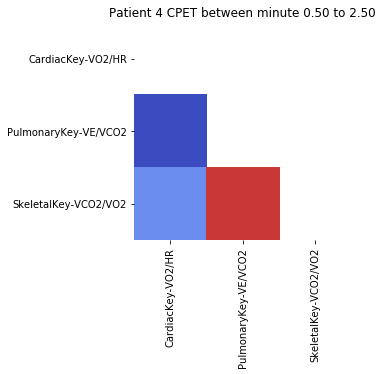

In [44]:
ani = generate_patient_heatmap_animated(4,df_info_avg)
HTML(ani.to_jshtml())

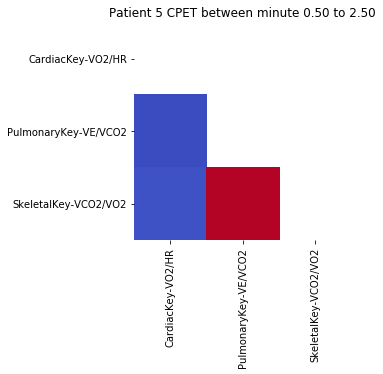

In [45]:
ani = generate_patient_heatmap_animated(5,df_info_avg)
HTML(ani.to_jshtml())

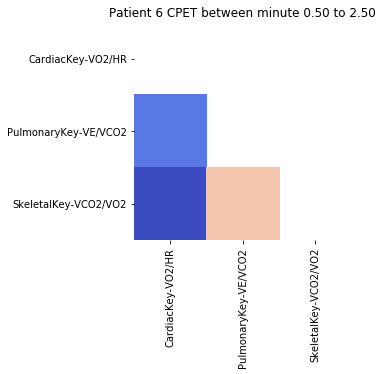

In [46]:
ani = generate_patient_heatmap_animated(6,df_info_avg)
HTML(ani.to_jshtml())

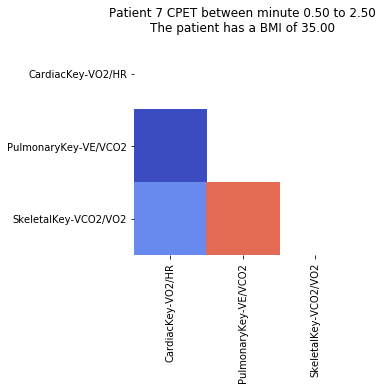

In [47]:
ani = generate_patient_heatmap_animated(7,df_info_avg)
HTML(ani.to_jshtml())

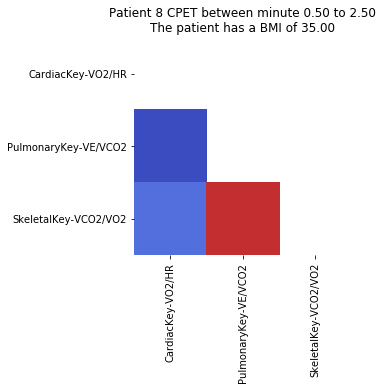

In [48]:
ani = generate_patient_heatmap_animated(8,df_info_avg)
HTML(ani.to_jshtml())

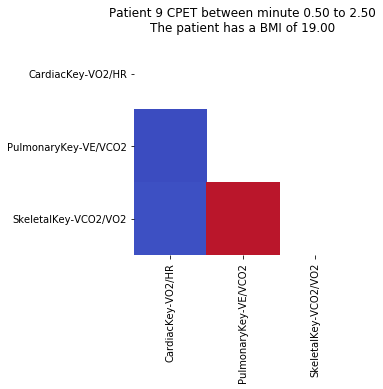

In [49]:
ani = generate_patient_heatmap_animated(9,df_info_avg)
HTML(ani.to_jshtml())

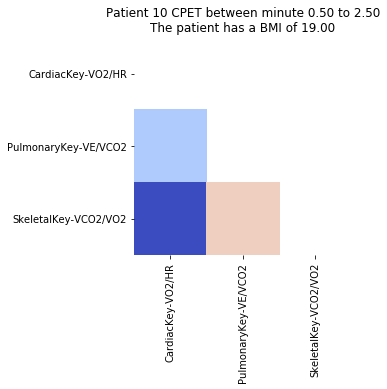

In [50]:
ani = generate_patient_heatmap_animated(10,df_info_avg)
HTML(ani.to_jshtml())

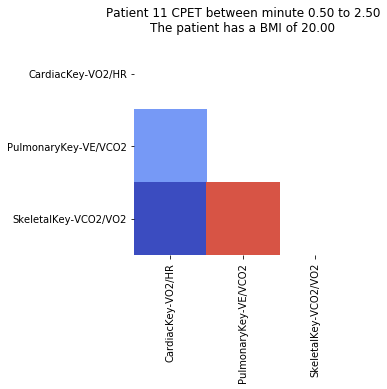

In [51]:
ani = generate_patient_heatmap_animated(11,df_info_avg)
HTML(ani.to_jshtml())

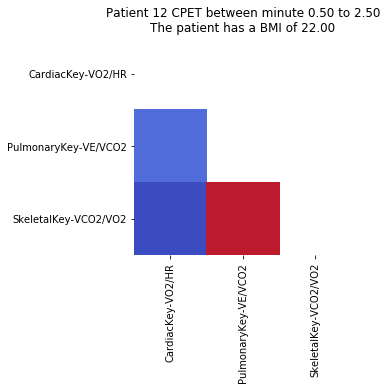

In [52]:
ani = generate_patient_heatmap_animated(12,df_info_avg)
HTML(ani.to_jshtml())

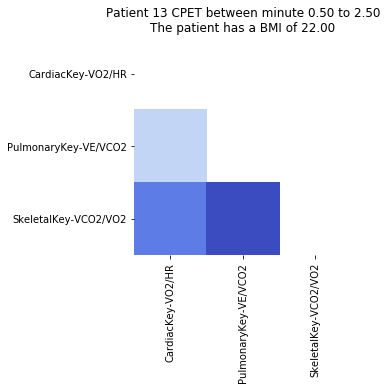

In [53]:
ani = generate_patient_heatmap_animated(13,df_info_avg)
HTML(ani.to_jshtml())

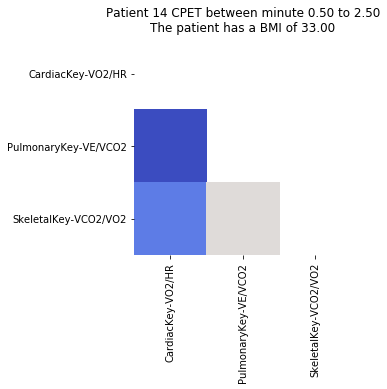

In [54]:
ani = generate_patient_heatmap_animated(14,df_info_avg)
HTML(ani.to_jshtml())

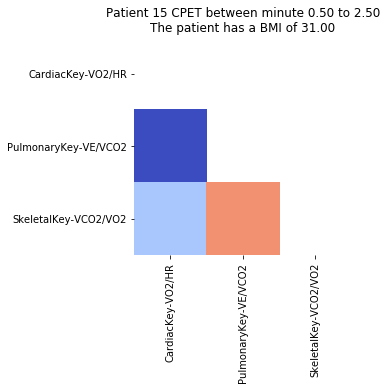

In [55]:
ani = generate_patient_heatmap_animated(15,df_info_avg)
HTML(ani.to_jshtml())

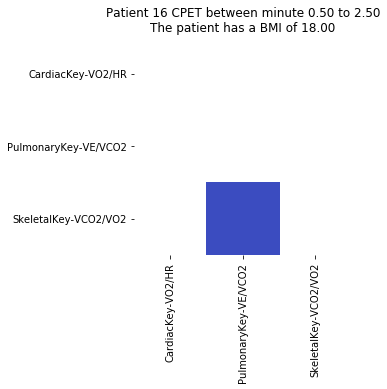

In [56]:
ani = generate_patient_heatmap_animated(16,df_info_avg)
HTML(ani.to_jshtml())

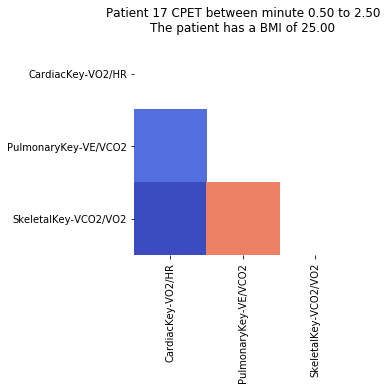

In [57]:
ani = generate_patient_heatmap_animated(17,df_info_avg)
HTML(ani.to_jshtml())

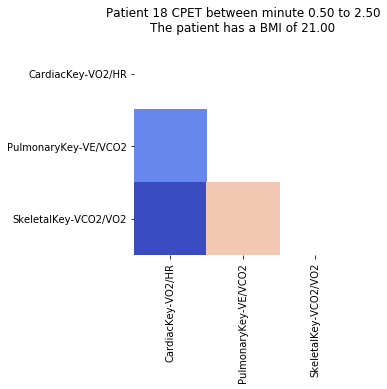

In [58]:
ani = generate_patient_heatmap_animated(18,df_info_avg)
HTML(ani.to_jshtml())

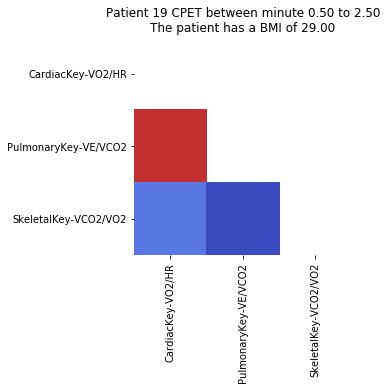

In [59]:
ani = generate_patient_heatmap_animated(19,df_info_avg)
HTML(ani.to_jshtml())

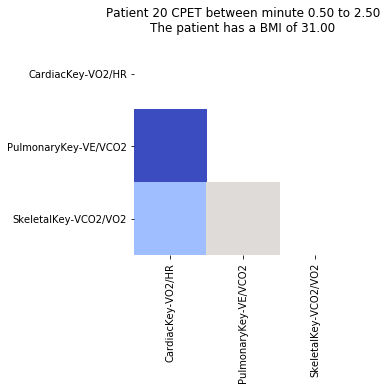

In [60]:
ani = generate_patient_heatmap_animated(20,df_info_avg)
HTML(ani.to_jshtml())

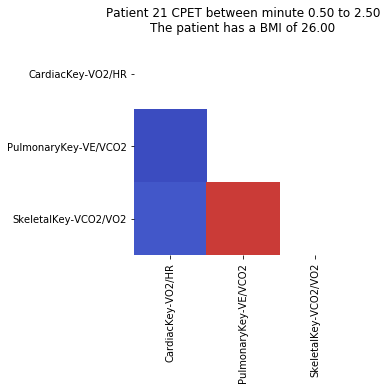

In [61]:
ani = generate_patient_heatmap_animated(21,df_info_avg)
HTML(ani.to_jshtml())

In [63]:
def generate_patient_heatmap_animated_old(patient_id, continues=False):
    df = final_info.copy()
    col_id = df.loc[df.PatientId==patient_id].ID.values
    fig, ax = plt.subplots()
    l, = ax.plot([],[])
    size_frame=4
    minutes = df.loc[df.PatientId==patient_id].minutes.values
    patient_info = final_info.loc[final_info.PatientId==patient_id][['age','sex','BMI']].values[0]
    t = range(0,minutes.shape[0]-size_frame, size_frame)
    def animate(i):
        cols = col_id[i:i+size_frame+1]
        minutes_range = minutes[i:i+size_frame+1]
        title = ""
        if math.isnan(patient_info[0]):
            title = "Patient {} CPET between minute {:.2f} to {:.2f}".format(patient_id,minutes_range[0],minutes_range[-1])
        else:
            title = "Patient {} CPET between minute {:.2f} to {:.2f}\nThe patient is a {:d} old {} with a BMI of {:.2f}".format(patient_id,minutes_range[0],minutes_range[-1],int(patient_info[0]),patient_info[1],patient_info[2])
        mask = np.zeros_like(df.loc[(df.PatientId==patient_id) & (df.ID.isin(cols))][['HR', 'VO2','VO2/kg', 'VCO2', 'RR', 'VE', 'VEO2', 'RER', 'FE02', 'FECO2', 'VECO2']].corr())
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(df.loc[(df.PatientId==patient_id) & (df.ID.isin(cols))][['HR', 'VO2','VO2/kg', 'VCO2', 'RR', 'VE', 'VEO2', 'RER', 'FE02', 'FECO2', 'VECO2']].corr(),mask=mask,cmap='coolwarm',annot=False, square=True, cbar=False, xticklabels=False).set_title(title)
        pass

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=t)
    return ani
    pass